<a href="https://colab.research.google.com/github/IsabelCamerini/SYSID-COURSEatPUC-Rio/blob/main/TakeHome9_Isabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import tensorflow as tf
from tensorflow import keras

import os
from os import mkdir

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from scipy import signal

# set random seed (reproducibility)
rseed = 42
np.random.seed(rseed)
tf.random.set_seed(rseed)
# print precision
np.set_printoptions(precision=3)

In [156]:
# Montar o drive para que o nosso script consiga acessar a base de dados.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
os.chdir('drive/MyDrive/SYSID/') 

FileNotFoundError: ignored

In [159]:
ls

 Atividade_6_SYSID.ipynb                    TakeHome9-Helon.ipynb
'Cópia de Cópia de TakeHome9-Helon.ipynb'   TakeHome9.ipynb
 robot_arm.dat                              Test_data.png
 Script_principal__E07_ANN.py               Train_data.png
 TakeHome6-Isabel.ipynb


In [160]:
data = np.loadtxt(r"robot_arm.dat", unpack = True)

u = data[0].reshape(-1,1)
y = data[1].reshape(-1,1)
N = u.shape[0]

ind = 0.7 #percent train/test

u_train = u[:int(ind*N)]
y_train = y[:int(ind*N)]

u_test = u[int(ind*N):]
y_test = y[int(ind*N):]

In [161]:
u_test.shape

(308, 1)

In [162]:
u_train.shape

(716, 1)

In [163]:
# def f_Narendra(x1,x2,x3,x4,x5):
#     return (x1*x2*x3*x5*(x3-1)+x4)/(1+x3**2+x2**2)



def matReg(y,u,ny,nu):
    # for debuging code
    # y= np.array([1, 2, 3,4,5,6,7,8,9,10])
    # u= np.array([1, 2, 3,4,5,6,7,8,9,10])

    p = np.max((ny,nu)) + 1
    (N, ) = y.shape
    (Nu, ) = u.shape
    
    # sanity check
    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1,-1)
    
    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny+nu))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    for i in range(nu):
        Phi[:,i+ny] = u[p-i-2: N - i-1]

    return (target, Phi)

def multiSine(fsample, fmax, T, A):
    
    Ts = 1/fsample
    Ndata1 = int(T/Ts)
    Nsines = int(Ndata1 - Ndata1*(fsample - fmax)/fsample)    # number of sines
    # f = np.arange(Ndata1)*fsample/Ndata1;                # multisine frequencies
    U = np.zeros(Ndata1,dtype=complex) # Fourier coefs.
    argExp = complex(0,1)*2*np.pi*np.random.uniform(size=(Nsines,))
    U[1:Nsines+1] = np.exp(argExp)
    aux = 2*np.real(np.fft.ifft(U))
    u = aux/abs(aux).max()*A # time value    
    
    return u

def freeRun(model, y, u,ny,nu):
    p = max(ny,nu) + 1 
    (N, ) = y.shape

    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1] # include initial conditions

    for k in range(p,N+1):
        # print(k)
        auxY = np.concatenate((  yhat[(k-p):(k-1)]   ,  (0,)   ),axis=0)
        auxU = np.concatenate((  u   [(k-p):(k-1)]   ,  (0,)   ),axis=0)
        
        _,fr_input = matReg(auxY,auxU,ny,nu)
        yhat[k-1] = model.predict(fr_input)
    # return only the values that are predictions
    # (remove the initial conditions)
    return yhat[-(N-p+1):] 

In [164]:
n_ue = int(5e4) # how many samples in the estimation dataset
n_uv = 800  # how many samples in the test       dataset

# ---- signal 1: sequence of random steps 
min_U = -1
max_U = 1
B = 4 # how many constant samples
aux = min_U + (max_U-min_U) * np.random.rand(int(n_ue/B))
ue = np.repeat(aux, B, axis=0) # sequence of random steps with B samples each
   


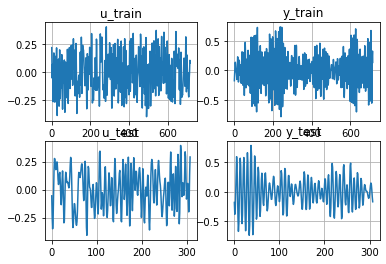

In [165]:
plt.figure()
plt.subplot(221)
plt.plot(u_train)
plt.title('u_train')
plt.grid()
plt.subplot(222)
plt.plot(y_train)
plt.title('y_train')
plt.grid()
plt.subplot(223)
plt.plot(u_test)
plt.title('u_test')
plt.grid()
plt.subplot(224)
plt.plot(y_test)
plt.title('y_test')
plt.grid()
plt.show()

In [176]:
utra = np.concatenate(( u_train  ),axis=0)
ytra = np.concatenate(( y_train  ),axis=0)

uval = np.concatenate(( u_test  ),axis=0)
yval = np.concatenate(( y_test  ),axis=0)


In [188]:
ny = 3
nu = 2 # model orders
(Ytra,Phitra) = matReg(ytra,utra,ny,nu)
(Yval,Phival) = matReg(yval,uval,ny,nu)


In [197]:
_ , ninp = Phitra.shape
nout = 1
nneu = 80 # how many neurons per layer

# model definition
input_ = keras.layers.Input(shape=(ninp,))
hidden1 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal",)(input_)
hidden2 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden1)
hidden3 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden2)
hidden4 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden3)
output = keras.layers.Dense(nout)(hidden4)

# instantiate model
model = keras.models.Model(inputs=[input_],outputs=[output])

# define optimizer and learning rate
optimizer = keras.optimizers.Nadam(lr = 1e-3)

# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [198]:
history = model.fit(Phitra, Ytra, epochs=300, batch_size = 32)

Epoch 1/300
23/23 [==============================] - 1s 2ms/step - loss: 0.0630
Epoch 2/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 3/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 4/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 5/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 6/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0039
Epoch 7/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 8/300
23/23 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 9/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 10/300
23/23 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 11/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 12/300
23/23 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 13/300
23/23 [=================

In [199]:
# One step ahead
# y_train_pred1 = model.predict(Phie)
y_test_pred1  = model.predict(Phitra)

R2test1  = r2_score(Ytra, y_test_pred1)
# R2train1 = r2_score(Ye, y_train_pred1)

print('-------------- One step ahead  --------------')
print('R2test1  =')
print(R2test1)
# print('R2train1  =')
# print(R2train1)

23/23 [==============================] - 0s 1ms/step
-------------- One step ahead  --------------
R2test1  =
0.998301010289517


In [200]:
# Free Run
# y_train_pred0 = freeRun(model,ytra,utra,ny,nu)
y_test_pred0  = freeRun(model,yval,uval,ny,nu)

# R2train0 = r2_score(Ytra, y_train_pred0)
R2test0  = r2_score(Yval, y_test_pred0)

print('-------------- Free Run  --------------')
print('R2test0  =')
print(R2test0)
# print('R2train0  =')
# print(R2train0)

1/1 [==============================] - 0s 19ms/step
-------------- Free Run  --------------
R2test0  =
0.7350284913680463


In [ ]:
plt.figure()
# plt.subplot(211)
# plt.plot(Ye,'k',y_train_pred0,'r')
# plt.title('Estimation')
# plt.legend(('real','prediction (FR)'))
# plt.grid()
# plt.subplot(211)
plt.plot(Yval,'k',y_test_pred0,'r')
plt.title('Test')
plt.legend(('real','prediction (OSA)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yval),min(y_test_pred0))
maxY = max(max(Yval),max(y_test_pred0))
plt.scatter(Yval,y_test_pred0,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()

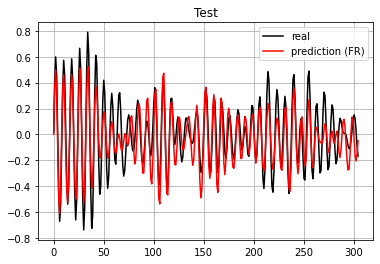

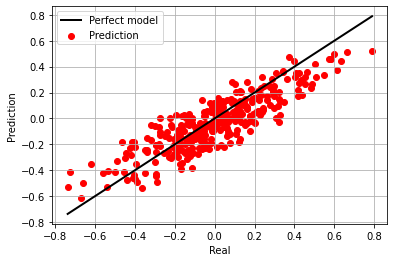

In [201]:
plt.figure()
# plt.subplot(211)
# plt.plot(Ye,'k',y_train_pred0,'r')
# plt.title('Estimation')
# plt.legend(('real','prediction (FR)'))
# plt.grid()
# plt.subplot(211)
plt.plot(Yval,'k',y_test_pred0,'r')
plt.title('Test')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yval),min(y_test_pred0))
maxY = max(max(Yval),max(y_test_pred0))
plt.scatter(Yval,y_test_pred0,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()